In [1]:
from groundedPL.codificacion import ToPropositionalLogic

parser = ToPropositionalLogic()
parser.debug = True

In [110]:
### AQUÍ SU CÓDIGO
from itertools import combinations
from groundedPL.logUtils import LogUtils
import sys

recursion = 10**9
sys.setrecursionlimit(recursion)

NUM_FILAS = 8
NUM_COLUMNAS = 8

casillas = [(x,y) for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)]
nums = range(9)

def vecinos(pos: tuple[int,int]):
    vecinos = [(x,y) for x in range(pos[0] - 1, pos[0] + 2) for y in range(pos[1] - 1, pos[1] + 2)]
    vecinos = [casilla for casilla in vecinos if casilla != pos and 0 <= casilla[0] < NUM_FILAS and 0 <= casilla[1] < NUM_COLUMNAS]
    return vecinos

def Ytoria(forms: list[str]) -> str:
    if len(forms) == 0:
        return None
    ytoria = '('
    if len(forms) > 0:
        for i in range(len(forms)):
            if(0 < i < len(forms)):
                ytoria += ' & '
            ytoria += forms[i]
        ytoria += ')'
    return ytoria

def Otoria(forms: list[str]) -> str:
    if len(forms) == 0:
        return None
    otoria = '('
    if len(forms) > 0:
        for i in range(len(forms)):
            if(0 < i < len(forms)):
                otoria += ' | '
            otoria += forms[i]
        otoria += ')'
    return otoria

#Regla 1: Cuando uan casilla no tiene una mina, tiene un numero.
def regla_1():
    formulas = []
    for casilla in casillas:
        formulas_otoria = []
        for num in nums:
            formula = parser.parse(f'NUM({casilla[0]},{casilla[1]},{num})')
            formulas_otoria.append(formula)
        otoria = Otoria(formulas_otoria)
        formula = parser.parse(f'-MINA({casilla[0]},{casilla[1]})') + ' = ' + otoria
        formulas.append(formula)
    return Ytoria(formulas)
        
#Regla 2: Una casilla debe contener un solo numero
def regla_2():
    formulas_ytoria = []
    formulas = []
    for casilla in casillas:
        x = casilla[0]
        y = casilla[1]
        for n in nums:
            formulas_ytoria = []
            for m in nums:
                if n != m:
                    formula = parser.parse(f'-NUM({x},{y},{m})')
                    formulas_ytoria.append(formula)
            ytoria = Ytoria(formulas_ytoria)
            formula = parser.parse(f'NUM({x},{y},{n})') + '->' + ytoria
            formulas.append(formula)
    return Ytoria(formulas)

            
#Regla 3: El numero de una casilla coincide con la cantidad de sus vecinos que contengan una mina.
def regla_3():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if(num > len(vec)):
                continue
            combinaciones = list(combinations(vec, num))
            formulas_otoria = []
            for S in combinaciones:
                ytoria_minas = []
                ytoria_vacia = []
                for mina in S:
                    formula = parser.parse(f'MINA({mina[0]},{mina[1]})')
                    ytoria_minas.append(formula)
                for vacia in vec:
                    if vacia not in S:
                        formula = parser.parse(f'-MINA({vacia[0]},{vacia[1]})')
                        ytoria_vacia.append(formula)
                minas = Ytoria(ytoria_minas)
                vacias = Ytoria(ytoria_vacia)
                if(vacias == None):
                    formula = minas
                elif(minas == None):
                    formula = vacias
                else:
                    formula = minas + '&' + vacias
                formulas_otoria.append(formula)
            otoria = Otoria(formulas_otoria)
            formula = parser.parse(f'NUM({casilla[0]},{casilla[1]},{num})') + '=' + otoria
            formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)

#Regla 4: Si una casilla es una mina, debe estar tapada. (De modo que no acabe el juego)
def regla_4():
    formulas = []
    for casilla in casillas:
        formula = parser.parse(f'MINA({casilla[0]},{casilla[1]})') + '->' + parser.parse(f'TAPADA({casilla[0]}, {casilla[1]})')
        formulas.append(formula)
    return Ytoria(formulas)

#------------Reglas de elección de casilla----------

#Regla 5: Una casilla (x,y) es seleccionable si y solo si no contiene una mina
def regla_5():
    formulas = []
    for casilla in casillas:
        formula = parser.parse(f'ELECCION({casilla[0]},{casilla[1]})') + '=' + parser.parse(f'-MINA({casilla[0]},{casilla[1]})')
        formulas.append(formula)
    return Ytoria(formulas)


#Regla 6:  Si una casilla destapada (x,y) contiene al numero n, y se tienen n vecinos marcados inseleccionables 
#(es decir, se dedujo que tienen una mina), el resto de vecinos tapados no son minas.
def regla_6():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if num > len(vec):
                continue
            combinaciones = list(combinations(vec, num))
            for S in combinaciones:
                if num == len(vec):
                    continue
                #izquierda
                formula = parser.parse(f'NUM({casilla[0]},{casilla[1]},{num})') + '&' + parser.parse(f'-TAPADA({casilla[0]},{casilla[1]})')
                minas = []
                for mina in S:
                    minas.append(parser.parse(f'MINA({mina[0]},{mina[1]})'))
                if len(minas) > 0:
                    formula += '&' + Ytoria(minas) 
                formula += ' -> '
                #derecha
                vacias = []
                for vecino in vec:
                    if vecino not in S:
                        vacias.append(parser.parse(f'-MINA({vecino[0]},{vecino[1]})'))

                formula += Ytoria(vacias)
                formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)


#Regla 7: Si una casilla destapada (x,y) contiene al numero n, y se tienen n vecinos tapados, entonces los vecinos tapados son minas.
def regla_7():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if num > len(vec):
                continue
            combinaciones = list(combinations(vec, num))
            for S in combinaciones:
                if num == 0:
                    continue
                formula = parser.parse(f'NUM({casilla[0]},{casilla[1]},{num})') + '&' + parser.parse(f'-TAPADA({casilla[0]},{casilla[1]})')
                tapados = []
                minas = []
                for vecino in vec:
                    if vecino in S:
                        tapados.append(parser.parse(f'TAPADA({vecino[0]},{vecino[1]})'))
                        minas.append(parser.parse(f'MINA({vecino[0]},{vecino[1]})'))
                    else:
                        tapados.append(parser.parse(f'-TAPADA({vecino[0]},{vecino[1]})'))

                if len(tapados) > 0:
                    formula += ' & ' + Ytoria(tapados)

                formula += ' -> ' + Ytoria(minas)

                formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)

def reglas():
    r = []
    print('regla1')
    r.append(regla_1())
    print('regla2')
    r.append(regla_2())
    print('regla3')
    r.append(regla_3())
    print('regla4')
    r.append(regla_4())
    print('regla5')
    r.append(regla_5())
    print('regla6')
    r.append(regla_6())
    print('regla7')
    r.append(regla_7())
    print('reglas terminadas')
    return LogUtils.Ytoria(r)
reglas()

regla1


regla2
regla3
regla4
regla5
regla6
regla7


KeyboardInterrupt: 

In [ ]:
### AQUÍ SU CÓDIGO
parser.debug = False
minas = [(2,1), (2,6), (3,1), (3,6), (7,1), (7,2), (7,7), (6,7), (5,7), (5,6), (5,5), (6,5), (7,5), (7,6)]


tablero = []
for i in range(NUM_FILAS):
    fila = []
    for j in range(NUM_COLUMNAS):
        fila.append(0)
    tablero.append(fila)

I = dict()

for tapada in minas:
    I[parser.parse(f'MINA({tapada[0]},{tapada[1]})')] = True
    I[parser.parse(f'TAPADA({tapada[0]},{tapada[1]})')] = True
    tablero[tapada[1]][tapada[0]] = '*'

    for vecino in vecinos(tapada):
        if type(tablero[vecino[1]][vecino[0]]) == int:
            tablero[vecino[1]][vecino[0]] += 1


for x in range(NUM_FILAS):
    for y in range(NUM_COLUMNAS):
        if tablero[y][x] != '*':
            num = tablero[y][x]
            I[parser.parse(f'MINA({x},{y})')] = False
            I[parser.parse(f'TAPADA({x},{y})')] = True
            I[parser.parse(f'NUM({x},{y},{num})')] = True

for fila in tablero:
    for casilla in fila:
        print(f'{str(casilla)}', end=', ')
    print('\n')

I[parser.parse(f'TAPADA({1},{0})')] = False
I[parser.parse(f'TAPADA({1},{1})')] = False
I[parser.parse(f'TAPADA({1},{2})')] = False
I[parser.parse(f'TAPADA({2},{2})')] = False

0, 1, 2, 2, 1, 0, 1, 1, 

0, 1, *, *, 1, 0, 2, *, 

0, 1, 2, 2, 1, 0, 2, *, 

0, 0, 0, 0, 0, 0, 1, 1, 

0, 0, 0, 0, 1, 2, 3, 2, 

0, 1, 2, 2, 3, *, *, *, 

0, 1, *, *, 4, *, 8, *, 

0, 1, 2, 2, 3, *, *, *, 



In [72]:
### AQUÍ SU CÓDIGO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar(I):
        # Inicializo el plano que contiene la figura
        fig, axes = plt.subplots()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)

        step = 1/NUM_FILAS
        tangulos = []
        font_size = step * 100
        colors = dict()
        colors[1] = (0,0,1)
        colors[2] = (0,0.5,0)
        colors[3] = (1,0,0)
        colors[4] = (0,0,0.5)
        colors[5] = (0.5,0,0)
        colors[6] = (0,0.5,0.5)
        colors[7] = (0,0,0)
        colors[8] = (0.5,0.5,0.5)

        # Creo los cuadrados claros en el tablero
        for atomo in I:
            if I[atomo]:
                # DECODIFICAMOS EL ÁTOMO PARA VISUALIZACIÓN
                predicado = parser.obtener_predicado(atomo)
                x, y, n = parser.obtener_argumentos(atomo)
                x = int(x)
                old_y = y
                y = NUM_COLUMNAS - int(y) - 1
                n = int(n)
                if predicado == 'TAPADA':
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='lightslategrey'))
                elif predicado == 'ELECCION':
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='green'))
                elif predicado == 'MINA' and not I[parser.parse(f'TAPADA({x},{old_y})')]:
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='red'))
                elif predicado == 'NUM' and n > 0 and not I[parser.parse(f'TAPADA({x},{old_y})')]:
                    plt.text(x * step + step / 2,
                             y * step + step / 2,
                             f'{n}',
                             fontsize=font_size,
                             color=colors[n])

        # Creo las líneas del tablero
        for j in range(8):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, step + locacion), 1, 0.005],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(step + locacion, 0), 0.005, 1],\
                    facecolor='black'))
        # Dibujo el tablero
        for t in tangulos:
            axes.add_patch(t)
        plt.show()

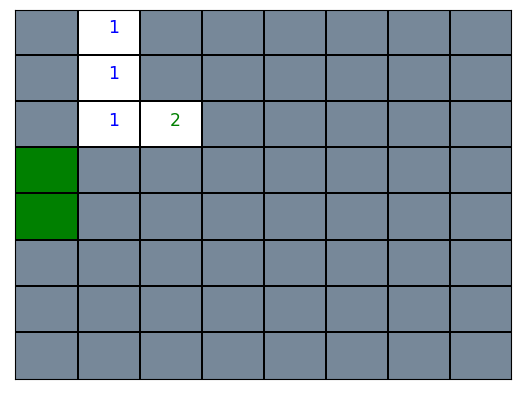

In [77]:
visualizar(I)